In [2]:
import hdbscan
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
import os
import json
from matplotlib.colors import LinearSegmentedColormap

import sys
from pathlib import Path
import warnings

from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.electronic_structure.dos import CompleteDos
from pymatgen.electronic_structure.plotter import BSDOSPlotter

from band_plotters import band_plot, bare_plot, check_plot

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', 1000)

In [3]:
MATERIAL_PATH = "../All_mat_new_test_score_with_horz_flat_index.csv"
#DATA_PATH = "../../data"

# "henry's local data path"
DATA_PATH = "../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA"

## Start with Anupam's list of materials

In [4]:
material_df = pd.read_csv("../All_mat_new_test_score_with_horz_flat_index.csv", index_col="ID")
print(material_df.shape)
material_df.head()

(5270, 24)


,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,decomp_eng,band_gap,point_group,crystal,A,B,C,D,E,F,radio,f_orb,sg_sto_group,percentage_flat
ID,,,,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,0.799800,0.0000,-3m,trigonal,F,Ir,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,0.300020,0.0000,-3m,trigonal,Ba,Sb,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,0.177410,0.9814,-1,triclinic,S,Tl,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,276.0,24.2
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,0.485820,0.0000,2/m,trigonal,Cl,Mo,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,0.011699,1.1619,-3m,trigonal,I,Ru,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN


In [5]:
# Select flat materials only
flat_df = material_df[material_df.horz_flat_seg > 0]
flat_df.shape

(2005, 24)

## Fingerprint Functions Here
Fingerprint functions take material ID as only input

array([28., 11., 44., 12.,  0.,  0.,  0.,  7., 47., 15., 17., 21.,  5.,
        3.,  2., 10., 13., 24., 21., 23., 35., 20., 40., 10.,  0.,  0.,
        0.,  0., 63., 19., 15.,  8.,  0.,  0.,  0.,  0., 13.,  8., 13.,
       22., 22., 19., 37., 16.,  0.,  0.,  0.,  8., 45., 17.,  6., 32.,
        5.,  3.,  3., 11., 15., 24., 28., 23.])

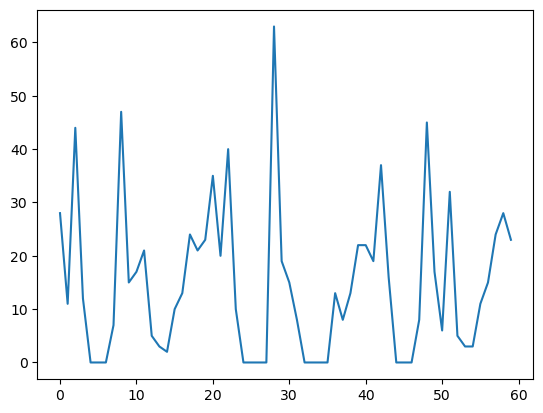

In [6]:
def calc_fingerprint(material_id, fingerprint_length, e_range=[-8, 8]):
    global edges
    filename_bands=DATA_PATH+"/bands/"+material_id+'.json'
    if not os.path.isfile(filename_bands):
        print("!!!! No such file %s" % filename_bands)
    bands_dict=json.load(open(filename_bands))

    fingerprint = np.zeros(fingerprint_length)
    
    k_branches = bands_dict["branches"]
    length_per_branch = fingerprint_length // len(k_branches)

    energies = np.array(bands_dict["bands"]["1"])
    
    # shift by fermi energy
    energies = energies-bands_dict["efermi"]

    for i, branch in enumerate(k_branches):
        branch_energies = energies[:, branch["start_index"]:branch["end_index"]+1]
        # print(i, branch_energies)
        counts, edges = np.histogram(branch_energies, bins=length_per_branch, range=e_range)
        fingerprint[i*length_per_branch : (i+1)*length_per_branch] = counts
    
    return fingerprint
    

fp = calc_fingerprint("2dm-1", 60)
plt.plot(fp)
fp

In [7]:
# re-run with all materials using this line
#flat_df = material_df

fingerprint_length = 60
finger_print_array = np.zeros([len(flat_df), fingerprint_length])

In [33]:
for i, material_id in enumerate(flat_df.index):
    if i % 100 == 0:
        print(i, "/", len(flat_df))

    finger_print_array[i, :] = calc_fingerprint(material_id, fingerprint_length)

print(finger_print_array)

0 / 2005
100 / 2005
200 / 2005
300 / 2005
400 / 2005
500 / 2005
600 / 2005
700 / 2005
800 / 2005
900 / 2005
1000 / 2005
1100 / 2005
1200 / 2005
1300 / 2005
1400 / 2005
1500 / 2005
1600 / 2005
1700 / 2005
1800 / 2005
1900 / 2005
2000 / 2005
[[  0.  63.  63. ... 110. 152. 248.]
 [  0.  41.  84. ... 151.  76.   0.]
 [  0.   0.   0. ...  74.  78.   0.]
 ...
 [  0.   0.  21. ...  19.  52.  64.]
 [ 14.  70. 126. ...   0.   0.  89.]
 [  0.   0.  17. ...  22.  87.  70.]]


In [34]:
df = flat_df.join(pd.DataFrame(finger_print_array, index=flat_df.index))
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,decomp_eng,band_gap,...,28,29,30,31,32,33,34,35,36,37,38,39
ID,,,,,,,,,,,,,,,,,,,,,,,,,
2dm-3,TlS,AB,2,4,4,0.84646,bottom-up,1,3,0.095794,0.177410,0.9814,...,105.0,173.0,0.0,86.0,40.0,128.0,187.0,39.0,51.0,110.0,152.0,248.0
2dm-21,TaI3,AB3,162,3,3,0.88201,bottom-up,1,1,0.097255,0.231110,0.0000,...,89.0,143.0,92.0,21.0,84.0,47.0,82.0,68.0,120.0,151.0,76.0,0.0
2dm-22,Li2O,AB2,164,3,3,0.96678,bottom-up,1,4,0.037593,0.187980,1.9866,...,0.0,0.0,39.0,119.0,31.0,0.0,28.0,53.0,53.0,74.0,78.0,0.0
2dm-25,VBr4,AB4,123,3,3,0.97834,bottom-up,1,2,0.140290,0.058544,0.0000,...,14.0,89.0,39.0,94.0,88.0,15.0,18.0,0.0,7.0,56.0,82.0,0.0
2dm-29,SBr,AB,2,4,4,0.82037,bottom-up,1,3,0.067035,0.035965,1.8022,...,27.0,179.0,0.0,42.0,84.0,119.0,133.0,0.0,84.0,29.0,13.0,134.0


In [35]:
#check for NaNs 
np.isnan(finger_print_array).sum()

0

In [36]:
df.isna().sum()[ df.isna().sum() != 0 ]

exfoliation_eg     606
decomp_eng          47
B                   10
C                 1124
D                 1752
E                 2005
F                 2005
dtype: int64

In [48]:
# save df
df.to_csv("materials_data_all_k_branches_fingerprint_60_SHIFTED_BY_FERMI_ENERGY.csv")

## Clustering

In [12]:
df = pd.read_csv("materials_data_all_k_branches_fingerprint_60_SHIFTED_BY_FERMI_ENERGY.csv")
fingerprint_length = 60
fingerprint_cols = [str(i) for i in range(fingerprint_length)]
fingerprint_array = df[fingerprint_cols]

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=4, min_samples=3, p=0.2)
clusterer.fit(fingerprint_array)

labels = clusterer.labels_
df["labels"] = labels
print(np.unique(labels, return_counts=True))
df[df.labels==1].head(19)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=int64), array([1658,    6,   17,    7,    9,    4,    5,    4,    4,    6,    5,
          6,    6,    4,    7,    9,    4,    4,   11,    6,    7,    5,
         28,    4,   12,    4,    6,   11,    4,    5,    5,    4,    4,
          6,    8,    4,    5,    4,   34,    6,    5,    4,    9,    6,
          4,    7,    4,    4,    8,    6], dtype=int64))


,ID,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,decomp_eng,...,49,50,51,52,53,54,55,56,57,58,59,labels
142,2dm-594,In2Se,AB2,143,3,3,0.93421,bottom-up,1,3,0.15842,0.129430,...,205.0,0.0,48.0,211.0,132.0,157.0,207.0,330.0,334.0,343.0,86.0,1
232,2dm-899,In2Te,AB2,143,3,3,0.92074,bottom-up,1,3,NaN,0.125990,...,190.0,0.0,58.0,272.0,167.0,169.0,239.0,339.0,418.0,186.0,0.0,1
233,2dm-900,Ga2Te,AB2,143,3,3,0.78315,bottom-up,1,3,NaN,0.259420,...,146.0,0.0,98.0,214.0,196.0,147.0,231.0,287.0,371.0,303.0,1.0,1
234,2dm-901,In2Se,AB2,143,3,3,0.96073,bottom-up,1,3,0.16124,0.130950,...,199.0,0.0,54.0,217.0,125.0,152.0,234.0,328.0,345.0,331.0,62.0,1
235,2dm-902,In2Te,AB2,143,3,3,0.94803,bottom-up,1,3,NaN,0.125450,...,182.0,0.0,64.0,261.0,165.0,171.0,254.0,345.0,402.0,186.0,0.0,1
236,2dm-903,Ga2Te,AB2,143,3,3,0.81656,bottom-up,1,3,0.22261,0.258060,...,145.0,0.0,91.0,212.0,189.0,157.0,232.0,281.0,373.0,300.0,13.0,1
240,2dm-910,Ga2Se,AB2,143,3,3,0.87920,bottom-up,1,3,0.19680,0.273440,...,154.0,0.0,26.0,204.0,156.0,169.0,163.0,239.0,353.0,351.0,187.0,1
442,2dm-1521,Tl2Te,AB2,143,3,3,0.97018,bottom-up,1,3,0.15880,0.055697,...,168.0,0.0,29.0,250.0,230.0,206.0,270.0,348.0,402.0,113.0,0.0,1
452,2dm-1554,Tl2Te,AB2,143,3,3,0.98755,bottom-up,1,3,0.15933,0.056779,...,167.0,0.0,23.0,268.0,213.0,207.0,259.0,357.0,422.0,99.0,0.0,1
466,2dm-1596,Tl2Se,AB2,143,3,3,0.96750,bottom-up,1,3,0.12758,0.000000,...,200.0,0.0,12.0,168.0,206.0,164.0,275.0,354.0,349.0,299.0,21.0,1


In [13]:
from ipywidgets import interact

def view_cluster(label):
    df_group = df[df.labels==label]
    display(df_group.head(100))

    num_plots = len(df_group)
    fig, ax = plt.subplots(num_plots, 1, figsize=(5, 1*num_plots))
    
    for i, index in enumerate(df[df.labels==label].index):

        # ax[i].bar(edges[:-1], df.loc[index][fingerprint_cols], align="edge", width=edges[1]-edges[0])?
        segments = int(np.array(df_group.segments)[i])
        energies_base = np.linspace(-8, 8, fingerprint_length)
#         energies = np.array([])
        
        for j in range(segments):
            ax[i].axvline(x=energies_base[int((fingerprint_length/segments)*(j+1))-1], linestyle="dashed", label="-8 to 8 eV segment")
#         print(energies)
            ax[i].plot(energies_base[:int(fingerprint_length/segments)*(j+1)-1], df.loc[index][fingerprint_cols][:int(fingerprint_length/segments)*(j+1)-1])
        

    
    
interact(view_cluster, label=(-1, len(np.unique(labels))-2, 1))

interactive(children=(IntSlider(value=23, description='label', max=48, min=-1), Output()), _dom_classes=('widg…

<function __main__.view_cluster(label)>

['2dm-2059' '2dm-2372' '2dm-2433' '2dm-2528' '2dm-2578' '2dm-2675']


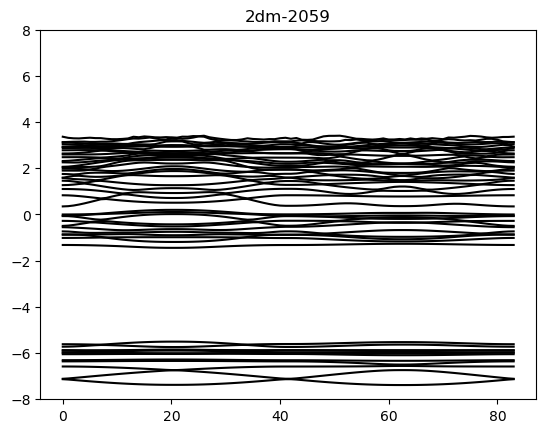

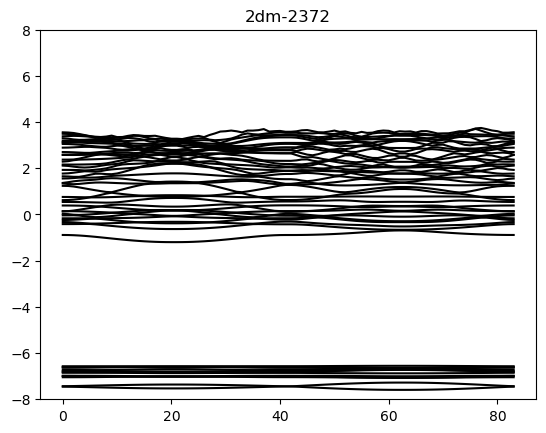

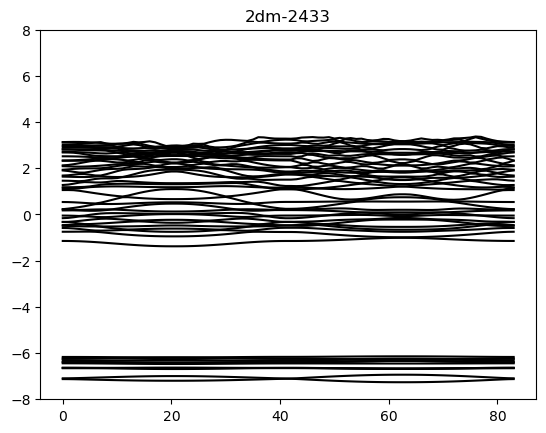

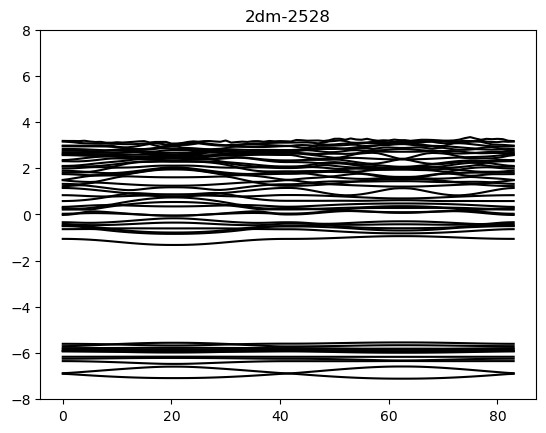

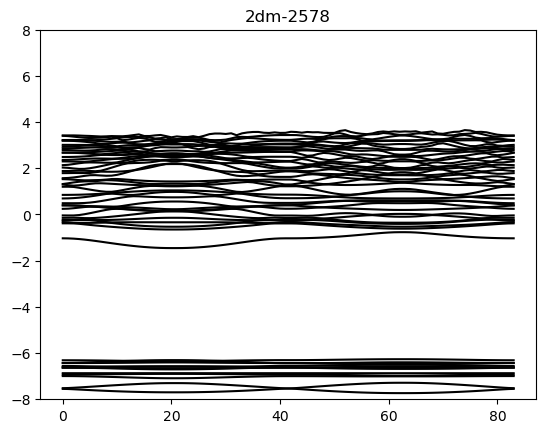

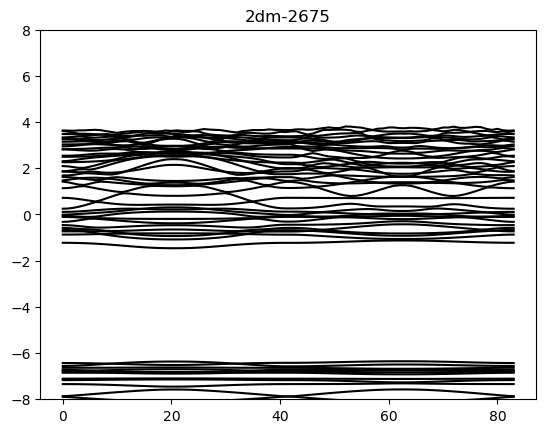

In [18]:
label = 13
num_plots = len(df[df.labels==label])

#fig, ax = plt.subplots(num_plots, 1, figsize=(5, 1*num_plots))

IDs = np.array(df[df.labels==label].ID)
print(IDs)
for i, ID in enumerate(IDs):
    #print(ID)
    # ax[i].bar(edges[:-1], df.loc[index][fingerprint_cols], align="edge", width=edges[1]-edges[0])?
    #ax[i].plot(np.linspace(-8, 8, fingerprint_length), df.loc[index][fingerprint_cols])
    #print(ID)
    #check_plot(ID, DATA_PATH, plot_dos=False)
    filename_bands = DATA_PATH+f"/bands/{ID}.json"
    if not os.path.isfile(filename_bands):
        raise FileNotFoundError("No such file %s" % filename_bands)
        
    bands_dict=json.load(open(filename_bands))
    bands = np.array(bands_dict["bands"]["1"])
    
    fig, ax = plt.subplots()
    ax.set_ylim([-8, 8])
    ax.set_title(ID)
    ax.ylabel="E"
    ax.xlabel="k-path"
    for band in bands:
        ax.plot(band, "k")
        
#plt.show()

## T-SNE Plot

In [15]:
n_components=2
tsne = manifold.TSNE(n_components=n_components, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=30 ,n_iter=10000, verbose=2)
fingerprints_2d = tsne.fit_transform(fingerprint_array)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.001s...
[t-SNE] Computed neighbors for 2005 samples in 0.322s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 136.899946
[t-SNE] Computed conditional probabilities in 0.164s
[t-SNE] Iteration 50: error = 73.2548676, gradient norm = 0.0116185 (50 iterations in 0.553s)
[t-SNE] Iteration 100: error = 72.5006866, gradient norm = 0.0001288 (50 iterations in 0.362s)
[t-SNE] Iteration 150: error = 72.4938965, gradient norm = 0.0001011 (50 iterations in 0.360s)
[t-SNE] Iteration 200: error = 72.4955139, gradient norm = 0.0001418 (50 iterations in 0.376s)
[t-SNE] Iteration 250: error = 72.4962463, gradient norm = 0.0001900 (50 iterations in 0.420s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.496246
[t-SNE] Iteration 300: er

[t-SNE] Iteration 4150: error = 1.1868718, gradient norm = 0.0002164 (50 iterations in 0.562s)
[t-SNE] Iteration 4200: error = 1.1868173, gradient norm = 0.0002341 (50 iterations in 0.556s)
[t-SNE] Iteration 4250: error = 1.1867356, gradient norm = 0.0002370 (50 iterations in 0.708s)
[t-SNE] Iteration 4300: error = 1.1867034, gradient norm = 0.0002216 (50 iterations in 0.627s)
[t-SNE] Iteration 4350: error = 1.1866250, gradient norm = 0.0002171 (50 iterations in 0.529s)
[t-SNE] Iteration 4400: error = 1.1865704, gradient norm = 0.0001603 (50 iterations in 0.573s)
[t-SNE] Iteration 4450: error = 1.1865103, gradient norm = 0.0002263 (50 iterations in 0.600s)
[t-SNE] Iteration 4500: error = 1.1865335, gradient norm = 0.0001643 (50 iterations in 0.524s)
[t-SNE] Iteration 4550: error = 1.1864971, gradient norm = 0.0001863 (50 iterations in 0.552s)
[t-SNE] Iteration 4600: error = 1.1864709, gradient norm = 0.0001653 (50 iterations in 0.609s)
[t-SNE] Iteration 4650: error = 1.1864406, gradien

[t-SNE] Iteration 8500: error = 1.1849778, gradient norm = 0.0001134 (50 iterations in 0.613s)
[t-SNE] Iteration 8550: error = 1.1849675, gradient norm = 0.0001226 (50 iterations in 0.596s)
[t-SNE] Iteration 8600: error = 1.1849391, gradient norm = 0.0001045 (50 iterations in 0.601s)
[t-SNE] Iteration 8650: error = 1.1849408, gradient norm = 0.0001194 (50 iterations in 0.581s)
[t-SNE] Iteration 8700: error = 1.1849217, gradient norm = 0.0001198 (50 iterations in 0.618s)
[t-SNE] Iteration 8750: error = 1.1849276, gradient norm = 0.0001239 (50 iterations in 0.633s)
[t-SNE] Iteration 8800: error = 1.1849205, gradient norm = 0.0001048 (50 iterations in 0.624s)
[t-SNE] Iteration 8850: error = 1.1849191, gradient norm = 0.0001594 (50 iterations in 0.620s)
[t-SNE] Iteration 8900: error = 1.1848776, gradient norm = 0.0002002 (50 iterations in 0.552s)
[t-SNE] Iteration 8950: error = 1.1849043, gradient norm = 0.0001179 (50 iterations in 0.568s)
[t-SNE] Iteration 9000: error = 1.1848643, gradien

C:\Users\hkpen\AppData\Local\Temp\ipykernel_10084\3318175735.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('turbo')


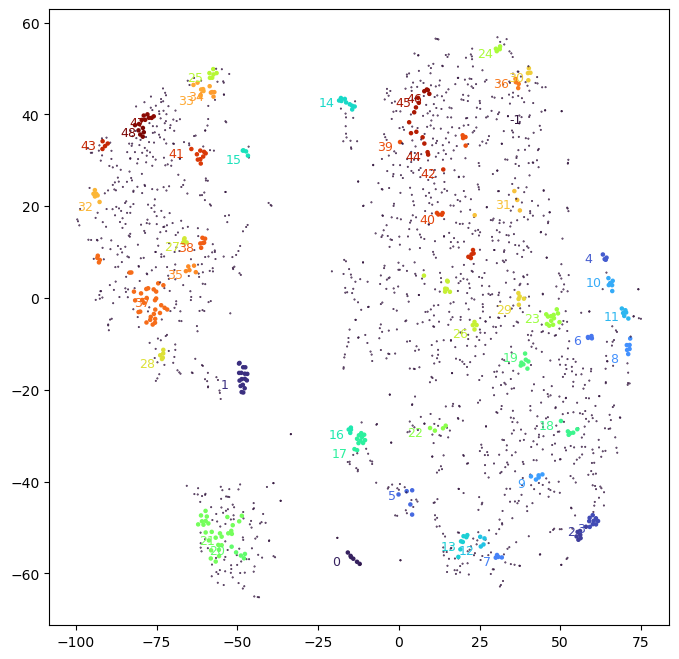

In [16]:
fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2
 
unique_label,cluster_rep_index, counts = np.unique(labels, return_index=True, return_counts=True)
cmap = plt.cm.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))
    
for rep_id in cluster_rep_index:
        col=cmap(norm(labels[rep_id]))
        plt.annotate(labels[rep_id],fingerprints_2d[rep_id,:]+[-4.5,-1],color=col,alpha=1, weight='normal', ha='center', va='center', size=9).draggable()

plt.scatter(fingerprints_2d[:,0], fingerprints_2d[:,1],s=size, c=labels*5, cmap="turbo")

<Axes: ylabel='$\\lambda$ value'>

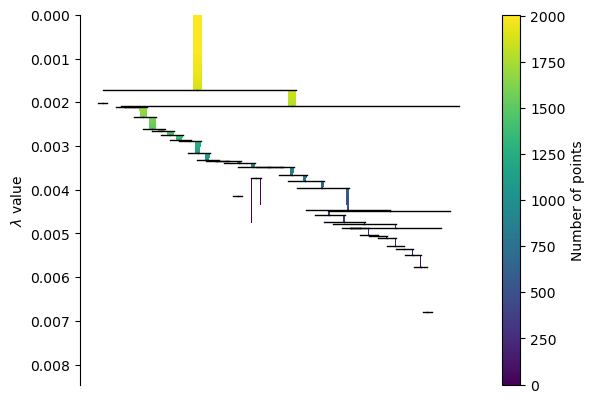

In [30]:
clusterer.condensed_tree_
clusterer.condensed_tree_.plot()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.001s...
[t-SNE] Computed neighbors for 2005 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 165.883147
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.255951
[t-SNE] KL divergence after 300 iterations: 1.839144


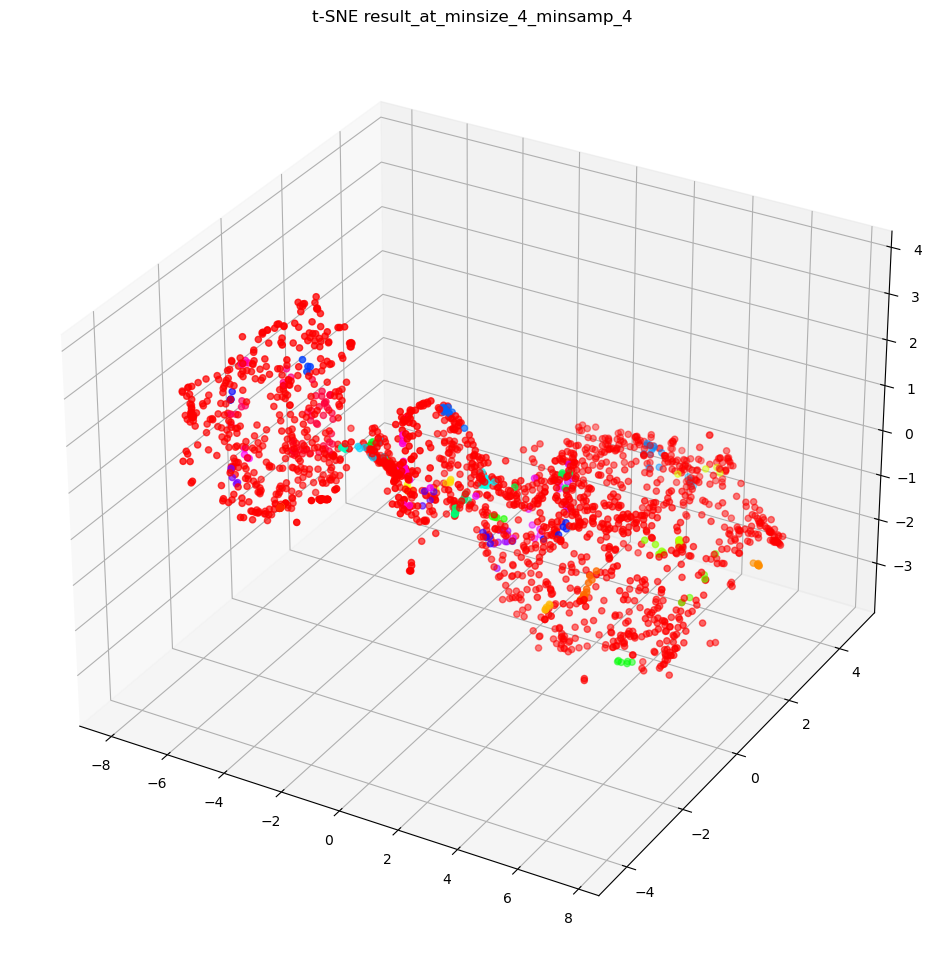

In [18]:
###################################
######### tSNE visualization 3D 
min_size=4
min_samp=4

tsne=manifold.TSNE(n_components=3, verbose=1, perplexity=50, n_iter=300)
ts= tsne.fit_transform(fingerprint_array)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
########
##### for different eps
# for i in np.arange(0.025,0.31,0.025):
#     eps=round(i, 3)
#     label=db.single_linkage_tree_.get_clusters(eps, min_cluster_size=3)
#     n_clusters_ = label.max()
#     n_noise_ = list(label).count(-1)
#     print(str(eps)+' '+str(len(labels))+' '+str(n_clusters_)+' '+str(n_noise_)+' '+str(metrics.silhouette_score(X, label)))
#     ax.scatter(ts[:,0], ts[:,1], ts[:,2], c=labels+1, cmap="hsv")
#     fname="t-SNE result_at_eps"+str(eps)
#     plt.title(fname)
#     plt.savefig(fname+'.png', bbox_inches='tight')
#     plt.show()
###########
###### for current minsize and minsamples
ax.scatter(ts[:,0], ts[:,1], ts[:,2], c=labels+1, cmap="hsv")
fname="t-SNE result_at_minsize_"+str(min_size)+"_minsamp_"+str(min_samp)
plt.title(fname)
plt.savefig(fname+'.png', bbox_inches='tight')
plt.show()